In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

from copy import deepcopy

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

import Preprocessor
import Parameters
import HHMM
import Visualisor

random.seed(0)
np.random.seed(0)

# Initialize parameters

In [2]:
ndives = 10
ndatasets = 1

# dive duration parameters
dd_mu = np.array([20.0,80.0])
dd_sig = np.array([5.0,50.0])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)
FoVeDBA_sin_shape = np.array([[(5.0/n) for n in range(1,52)],[(5.0/n) for n in range(1,52)]])
FoVeDBA_sin_scale = np.ones((2,51))
FoVeDBA_sin_shape[1,1] = 250
FoVeDBA_sin_shape[1,2] = 50

# average acceleration parameters
acc_mu = np.array([0.0,0.0])
acc_sig = np.array([0.05,0.1])

# number of states for each substate
K0 = 2
K1 = 2

# randomly initialize a probablity transition matrix
ptm_crude = np.array([[0.5,0.5],
                      [0.5,0.5]])

ptm_fine = [np.array([[0.5,0.5],
                      [0.1,0.9]]),
            np.array([[0.8,0.2],
                      [0.3,0.7]])]
    
# randomly intialize a correlation within states
corr_crude = [0.0,0.0]
corr_fine = [0.99,0.95]

# train new models?
train_new = True

In [3]:
# initialize the initial states
delta_crude = np.ones(K0)/K0
for _ in range(100):
    delta_crude = delta_crude.dot(ptm_crude)
    
delta_fines = []
for k0 in range(K0):
    delta_fine = np.ones(K1)/K1
    for _ in range(100):
        delta_fine = delta_fine.dot(ptm_fine[k0])
    delta_fines.append(delta_fine)

# Create Data 

In [4]:
def create_data():
    
    data = []
    data_V = []
    data_FV = []
    freqs = np.fft.rfftfreq(100, d=1/50.0)
    thresh = 5
    thresh_ind = max(np.where(freqs <= thresh)[0]) + 1
    
    time = 0
    
    for dive_num in range(ndives):
        
        # select dive type
        if dive_num == 0:
            dive_type = np.random.choice(K0,p=delta_crude)
            dd_mu_t = np.copy(dd_mu[dive_type])
        else:
            dive_type_tm1 = dive_type
            dive_type = np.random.choice(K0,p=ptm_crude[dive_type,:])
            dd_mu_t = np.copy(dd_mu[dive_type])
            dd_mu_t = corr_crude[dive_type]*dd_tm1 + (1.0-corr_crude[dive_type])*dd_mu_t

        # select dive duration
        dd_sig_t = dd_sig[dive_type]
        dd_shape_t = np.square(dd_mu_t)/np.square(dd_sig_t)
        dd_scale_t = np.square(dd_sig_t)/np.array(dd_mu_t)

        dive_duration = gamma.rvs(dd_shape_t,0,dd_scale_t)
        dd_tm1 = dive_duration
        datum = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_V = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_FV = {'dive_type': dive_type, 'dive_duration': dive_duration}
        nsegs = int(dive_duration/2.0)

        subdive_features = []
        subdive_features_V = []
        subdive_features_FV = []

        for seg_num in range(nsegs):
            
            seg = {}
            seg_V = [{},{}]
            seg_FV = {}

            # find seg type
            if seg_num == 0:
                subdive_type = np.random.choice(K1,p=delta_fines[dive_type])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
            else:
                subdive_type = np.random.choice(K1,p=ptm_fine[dive_type][subdive_type,:])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
                acc_mu_t = corr_fine[subdive_type]*acc_tm1 + (1.0-corr_fine[subdive_type])*acc_mu_t

            seg['subdive_type'] = subdive_type
            seg_FV['subdive_type'] = subdive_type
            seg_V[0]['subdive_type'] = subdive_type
            seg_V[1]['subdive_type'] = subdive_type

            # find average acceleration
            acc_sig_t = acc_sig[subdive_type]

            # find FoVeDBA
            FoVeDBA_sin_sig2_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]**2
            FoVeDBA_sin_shape_t = np.square(FoVeDBA_sin_mu_t)/FoVeDBA_sin_sig2_t
            FoVeDBA_sin_scale_t = FoVeDBA_sin_sig2_t/FoVeDBA_sin_mu_t
            FoVeDBA_sin = gamma.rvs(FoVeDBA_sin_shape_t,0,FoVeDBA_sin_scale_t)
            FoVeDBA_sin_tm1 = np.copy(FoVeDBA_sin)

            seg['FoVeDBA_full'] = FoVeDBA_sin.T
            seg['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
            seg_FV['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001

            # find VeDBA
            pm = (2*np.random.choice(2,size = FoVeDBA_sin.shape)-1)
            FoVeDBA = pm*np.sqrt(FoVeDBA_sin)*1.0j
            A = np.array(np.fft.irfft(FoVeDBA))
            V0 = norm.rvs(acc_mu_t,acc_sig_t)
            acc_tm1 = V0
            A += np.linspace(V0,V0,100).T

            seg['A'] = A
            seg['avg_A'] = np.mean(A)
            seg_V[0]['A'] = np.mean(A[:50])
            seg_V[1]['A'] = np.mean(A[50:])
            seg_FV['A'] = np.mean(A)

            # find time
            seg['time'] = np.arange(time,time+2,1/50)
            time += 2

            subdive_features.append(seg)
            subdive_features_V.append(seg_V[0])
            subdive_features_V.append(seg_V[1])
            subdive_features_FV.append(seg_FV)

        datum['subdive_features'] = subdive_features
        datum_V['subdive_features'] = subdive_features_V
        datum_FV['subdive_features'] = subdive_features_FV

        data.append(datum)
        data_V.append(datum_V)
        data_FV.append(datum_FV)
        
    return data,data_V,data_FV

data,data_V,data_FV = create_data()

# Visualize Data 

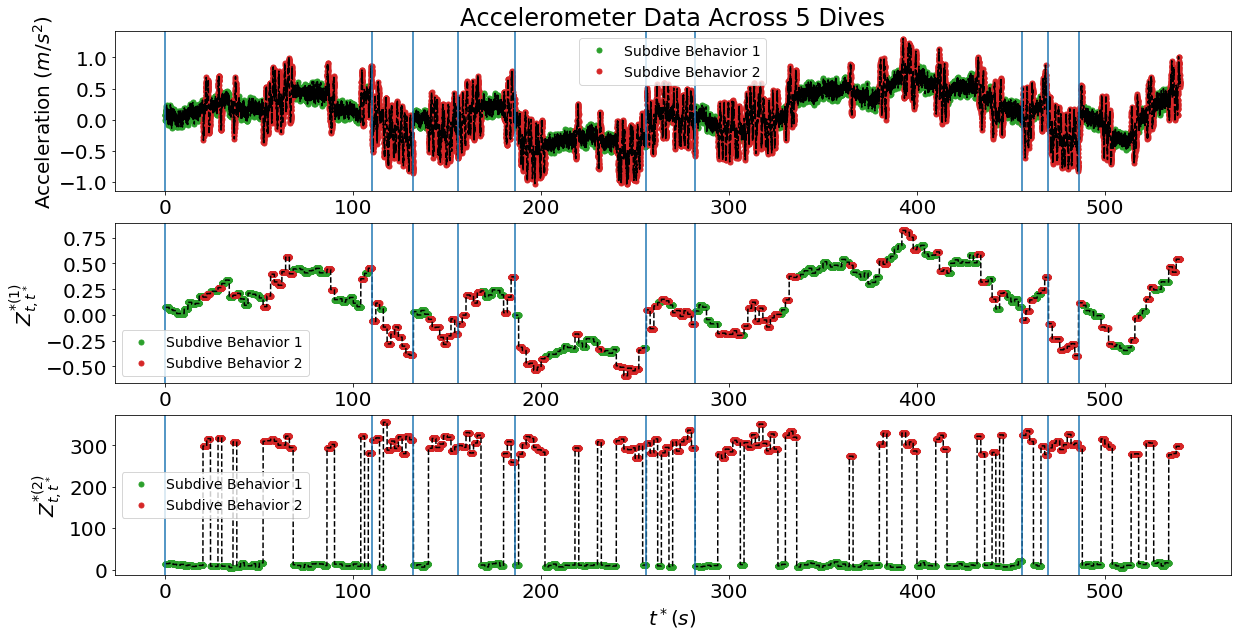

In [5]:
dive_colors = [cm.get_cmap('tab10')(i) for i in range(K0)]
dive_legend = ['Dive Type %d' % (i+1) for i in range(K0)]

subdive_colors = [cm.get_cmap('tab10')(i+K0) for i in range(K1)]
subdive_legend = ['Subdive Behavior %d' % (i+1) for i in range(K1)]

def plot_col(col,data,color,level,nplots,subplot):

    dive_starts = []
    
    if color == 'dive':
        x = [list([]) for _ in range(K0+1)]
        y = [list([]) for _ in range(K0+1)]
    else:
        x = [list([]) for _ in range(K1+1)]
        y = [list([]) for _ in range(K1+1)]
    
    plt.subplot(nplots,1,subplot)
    for datum in data[:10]:
        dive_type = datum['dive_type']
        dive_starts.append(datum['subdive_features'][0]['time'][0])

        for seg in datum['subdive_features']:
            subdive_type = seg['subdive_type']
            
            if col not in seg:
                continue
            
            if level == 0:
                seg_data = [seg[col]]*len(seg['time'])
            else:
                seg_data = seg[col]
            
            x[-1].extend(seg['time'])
            y[-1].extend(seg_data)
            if color == 'dive':
                x[dive_type].extend(seg['time'])
                y[dive_type].extend(seg_data)
            else:
                x[subdive_type].extend(seg['time'])
                y[subdive_type].extend(seg_data)

    if color == 'dive':
        c = dive_colors
        l = dive_legend
    else:
        c = subdive_colors
        l = subdive_legend

    for state in range(K0):
        plt.plot(x[state],y[state],'.',color=c[state],markersize=10)
    
    plt.legend(l,prop={'size': 14})
    plt.plot(x[-1],y[-1],'k--')
    
    for dive_start in dive_starts:
        plt.axvline(x=dive_start)
    
    return

plt.subplots(2,1,figsize=(20,10))
plot_col('A',data,'subdive',1,3,1)
plt.title('Accelerometer Data Across 5 Dives', fontsize = 24)
plt.ylabel('Acceleration $(m/s^2)$', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plot_col('avg_A',data,'subdive',0,3,2)
plt.ylabel('$Z^{*(1)}_{t,t^*}$',fontsize = 20)
plt.xlabel('$t^*(s)$',fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plot_col('FoVeDBA',data,'subdive',0,3,3)
plt.ylabel('$Z^{*(2)}_{t,t^*}$',fontsize = 20)
plt.xlabel('$t^*(s)$',fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("../Plots/sim_data.png")

# Find intial thetas for training

In [6]:
### CarHMM ###
hmm_FV_theta = [{'dive_duration': {'mu': np.array([np.mean(dd_mu)]),
                                   'sig': np.array([np.sqrt(np.mean(dd_sig**2) + np.var(dd_mu))]),
                                   'corr': np.array([-10.])}},
                 [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

ptm_fine_temp = ptm_fine[0]/2 + ptm_fine[1]/2

hmm_FV_eta = [np.array([[0]]),
             [np.array([[0,np.log(1.0/ptm_fine_temp[0,0]-1)],
                        [np.log(1.0/ptm_fine_temp[1,1]-1),0]])]]


### CarHHMM, no Z2 ###
hhmm_V_theta = [{'dive_duration': {'mu': dd_mu,
                                   'sig': dd_sig,
                                   'corr': np.array([-10.,-10.])}},
                 [{'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                  {'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_V_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                        [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
             [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                        [np.log(1.0/ptm_fine[0][1,1]-1),0]]),
              
              np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                        [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]


### HHMM ###
hhmm_FV_uncorr_theta = [{'dive_duration': {'mu': dd_mu,
                                           'sig': dd_sig,
                                           'corr': np.array([-10.,-10.])}},
                         [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                                       'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                                       'corr': np.array([ -10., -10.])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([-10.,-10.])}},
                          {'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                                       'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                                       'corr': np.array([ -10., -10.])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([-10.,-10.])}}]]

hhmm_FV_uncorr_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                                [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
                      [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                                 [np.log(1.0/ptm_fine[0][1,1]-1),0]]),

                       np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                                 [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]

### CarHHMM ###
hhmm_FV_theta = [{'dive_duration': {'mu': dd_mu,
                                    'sig': dd_sig,
                                    'corr': np.array([-10.,-10.])}},
                 [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig, 
                         'corr': logit(corr_fine)}},
                 {'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig, 
                         'corr': logit(corr_fine)}}]]

hhmm_FV_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                         [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
               [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                          [np.log(1.0/ptm_fine[0][1,1]-1),0]]),

                np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                          [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]

# Try to relearn generative parameters many times

In [7]:
datasets = []
datasets_V = []
datasets_FV = []

hmm_FVs = []
hhmm_Vs = []
hhmm_FV_uncorrs = []
hhmm_FVs = []

for dataset_num in range(ndatasets):
    
    
    ### generate data ###
    print('')
    print('GENERATING DATA')
    print('')
    data,data_V,data_FV = create_data()
    
    
    ### CarHMM ###
    print('')
    print('STARTING CarHMM')
    print('')
    pars = Parameters.Parameters()
    pars.K = [1,2]
    pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                     {'FoVeDBA':{'corr':False,'f':'gamma'},
                      'A':{'corr':True,'f':'normal'}}]
    pars.theta = hmm_FV_theta

    hmm_FV = HHMM.HHMM(pars,data_FV)
    hmm_FV.theta = hmm_FV_theta
    hmm_FV.eta = hmm_FV_eta
    hmm_FV.true_theta = deepcopy(hmm_FV_theta)
    hmm_FV.true_eta = deepcopy(hmm_FV_eta)

    if train_new:
        hmm_FV.train_DM(data_FV)
        hmm_FV.save('../Params/hmm_FV_%d'%dataset_num)
    else:
        hmm_FV = hmm_FV.load('../Params/hmm_FV_%d'%dataset_num)

    for dive_num,datum in enumerate(data_FV):
        _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
        for i,post in enumerate(posts.T):
            data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
            data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]


    ### HHMM ###
    print('')
    print('STARTING HHMM')
    print('')
    pars = Parameters.Parameters()
    pars.K = [2,2]
    pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                     {'FoVeDBA':{'corr':False,'f':'gamma'},
                      'A':{'corr':False,'f':'normal'}}]
    
    hhmm_FV_uncorr = HHMM.HHMM(pars,data_FV)
    hhmm_FV_uncorr.theta = hhmm_FV_uncorr_theta
    hhmm_FV_uncorr.eta = hhmm_FV_uncorr_eta
    hhmm_FV_uncorr.true_theta = deepcopy(hhmm_FV_uncorr_theta)
    hhmm_FV_uncorr.true_eta = deepcopy(hhmm_FV_uncorr_eta)

    if train_new:
        hhmm_FV_uncorr.train_DM(data_FV)
        hhmm_FV_uncorr.save('../Params/hhmm_FV_uncorr_%d'%dataset_num)
    else:
        hhmm_FV_uncorr = hhmm_FV_uncorr.load('../Params/hhmm_FV_uncorr_%d'%dataset_num)

    # crude posterior
    _,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

    # fine posterior
    for dive_num,datum in enumerate(data_FV):
        data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
        _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
        _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
        for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
            p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                posts_crude.T[dive_num,1]*post_fine_1[1]
            data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
            data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]


    ### CarHHMM, no Z2 ###
    print('')
    print('STARTING CarHHMM minux Z2')
    print('')
    pars = Parameters.Parameters()
    pars.K = [2,2]
    pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                     {'A':{'corr':True,'f':'normal'}}]
    
    hhmm_V = HHMM.HHMM(pars,data_V)
    hhmm_V.theta = hhmm_V_theta
    hhmm_V.eta = hhmm_V_eta
    hhmm_V.true_theta = deepcopy(hhmm_V_theta)
    hhmm_V.true_eta = deepcopy(hhmm_V_eta)

    if train_new:
        hhmm_V.train_DM(data_V)
        hhmm_V.save('../Params/hhmm_V_%d'%dataset_num)
    else:
        hhmm_V = hhmm_V.load('../Params/hhmm_V_%d'%dataset_num)

    # crude posterior
    _,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

    # fine posterior
    for dive_num,datum in enumerate(data_V):
        data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
        _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
        _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
        for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
            p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                posts_crude.T[dive_num,1]*post_fine_1[1]
            if i%2 == 0:
                p0 = p
            else:
                data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
                data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]


    ### CarHHMM ###
    print('')
    print('STARTING CarHHMM')
    print('')
    pars = Parameters.Parameters()
    pars.K = [2,2]
    pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                     {'FoVeDBA':{'corr':False,'f':'gamma'},
                      'A':{'corr':True,'f':'normal'}}]
    
    hhmm_FV = HHMM.HHMM(pars,data_FV)
    hhmm_FV.theta = hhmm_FV_theta
    hhmm_FV.eta = hhmm_FV_eta
    hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
    hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

    if train_new:
        hhmm_FV.train_DM(data_FV)
        hhmm_FV.save('../Params/hhmm_FV_%d'%dataset_num)
    else:
        hhmm_FV = hhmm_FV.load('../Params/hhmm_FV_%d'%dataset_num)

    # crude posterior
    _,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

    # fine posterior
    for dive_num,datum in enumerate(data_FV):
        _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
        _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
        for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
            p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                posts_crude.T[dive_num,1]*post_fine_1[1]
            data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
            data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]
            
            
    # record data
    datasets.append(data)
    datasets_V.append(data_V)
    datasets_FV.append(data_FV)
    
    # record hmms
    hmm_FVs.append(hmm_FV)
    hhmm_Vs.append(hhmm_V)
    hhmm_FV_uncorrs.append(hhmm_FV_uncorr)
    hhmm_FVs.append(hhmm_FV)


GENERATING DATA


STARTING CarHMM


STARTING HHMM


STARTING CarHHMM minux Z2


STARTING CarHHMM



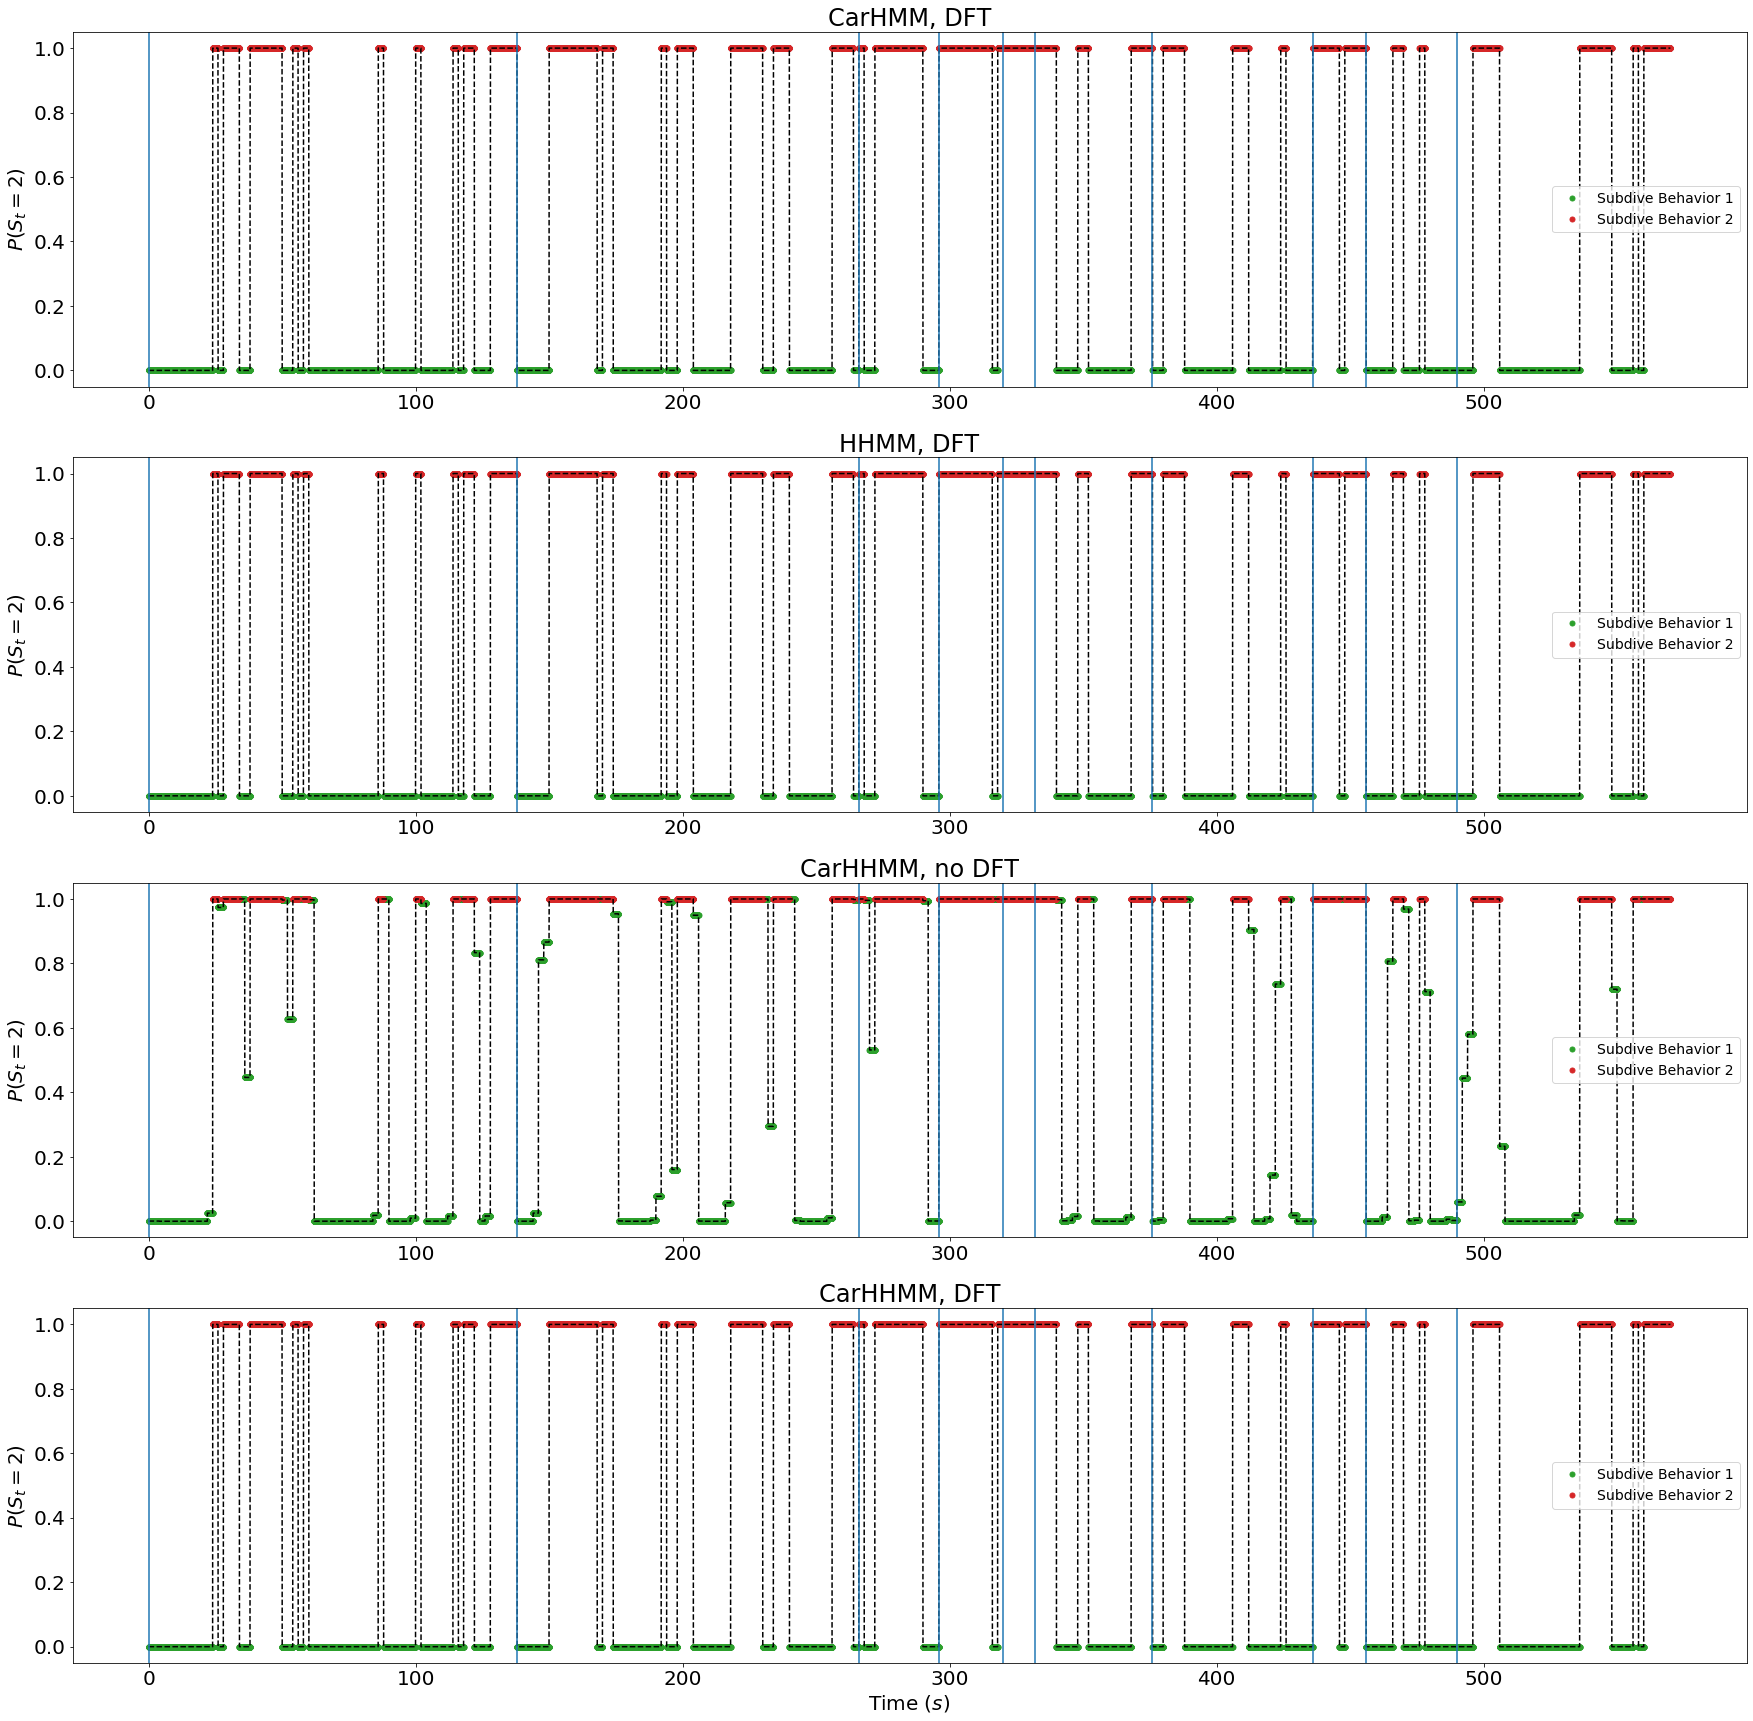

In [8]:
data = datasets[0]

plt.subplots(3,1,figsize=(30,30))

plot_col('hmm_FV_subdive',data,'subdive',0,4,1)
plt.title("CarHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)

plot_col('hhmm_FV_uncorr_subdive',data,'subdive',0,4,2)
plt.title("HHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)

plot_col('hhmm_V_subdive',data,'subdive',0,4,3)
plt.title("CarHHMM, no DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)


plot_col('hhmm_FV_subdive',data,'subdive',0,4,4)
plt.title("CarHHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)
plt.xlabel('Time ($s$)',fontsize=20)

plt.savefig('../Plots/Posterior_States_Sim.png')

In [9]:
hmm_FV.theta

[{'dive_duration': {'mu': array([57.76752554]),
   'sig': array([40.74301751]),
   'corr': array([-10.27941362])}},
 [{'FoVeDBA': {'mu': array([ 10.72006219, 304.97661986]),
    'sig': array([ 3.23315961, 15.96137966]),
    'corr': array([-16.33570196, -11.29684899])},
   'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([5.27863392, 5.22465891])}}]]

In [10]:
hhmm_V.theta

[{'dive_duration': {'mu': array([21.923476  , 79.65790146]),
   'sig': array([ 6.80581886, 40.41639037]),
   'corr': array([-13.16621634, -11.26128552])}},
 [{'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([5.03922147, 0.55975592])}},
  {'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([5.03922147, 0.55975592])}}]]

In [11]:
hhmm_FV_uncorr.theta

[{'dive_duration': {'mu': array([21.923476  , 79.65790146]),
   'sig': array([ 6.80581886, 40.41639037]),
   'corr': array([ -6.60315162, -11.92653555])}},
 [{'FoVeDBA': {'mu': array([ 10.72006219, 304.97661986]),
    'sig': array([ 3.23315961, 15.96137966]),
    'corr': array([-16.33570196, -11.29684899])},
   'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([-2.45042645, -1.26621343])}},
  {'FoVeDBA': {'mu': array([ 10.72006219, 304.97661986]),
    'sig': array([ 3.23315961, 15.96137966]),
    'corr': array([-16.33570196, -11.29684899])},
   'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([-2.45042645, -1.26621343])}}]]

In [12]:
hhmm_FV.theta

[{'dive_duration': {'mu': array([21.923476  , 79.65790146]),
   'sig': array([ 6.80581886, 40.41639037]),
   'corr': array([ -7.11670188, -10.18239018])}},
 [{'FoVeDBA': {'mu': array([ 10.72006219, 304.97661986]),
    'sig': array([ 3.23315961, 15.96137966]),
    'corr': array([-16.33570196, -11.29684899])},
   'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([5.31256173, 5.21105557])}},
  {'FoVeDBA': {'mu': array([ 10.72006219, 304.97661986]),
    'sig': array([ 3.23315961, 15.96137966]),
    'corr': array([-16.33570196, -11.29684899])},
   'A': {'mu': array([-6.47349754e-06, -5.03285495e-03]),
    'sig': array([0.04940021, 0.10366592]),
    'corr': array([5.31256173, 5.21105557])}}]]

In [13]:
h = 0.01

print('theta coarse: \n \n')
# coarse-scale theta
for feature in hhmm_FV.theta[0]:
    for param in hhmm_FV.theta[0][feature]:
        for state_num,theta in enumerate(hhmm_FV.theta[0][feature][param]):

            # get middle value
            th_t = hhmm_FV.likelihood(data_FV)

            # get plus value
            hhmm_FV.theta[0][feature][param][state_num] += h
            th_tp1 = hhmm_FV.likelihood(data_FV)

            # get minus value
            hhmm_FV.theta[0][feature][param][state_num] += -2*h
            th_tm1 = hhmm_FV.likelihood(data_FV)

            # return theta
            hhmm_FV.theta[0][feature][param][state_num] += h

            # get estimate
            I_th = (2*th_t - th_tm1 - th_tp1)/(h**2)
            V_th = 1.0/I_th
            sig_th = np.sqrt(V_th)
            
            # get confidence interval
            CI_low = theta - 1.96*sig_th
            CI_high = theta + 1.96*sig_th

            # adjust if param is corr
            if param == 'corr':
                theta = expit(theta)
                CI_low = expit(CI_low)
                CI_high = expit(CI_high)
                
            print('%s %s state %d:' % (param,feature,state_num))
            print(theta)
            print('95%% CI: [%f,%f]' % (CI_low,CI_high))
            print('')

            
print('theta fine: \n \n')
# fine-scale theta
for feature in hhmm_FV.theta[1][0]:
    for param in hhmm_FV.theta[1][0][feature]:
        for state_num,state_theta in enumerate(hhmm_FV.theta[1][0][feature][param]):

            # get middle value
            th_t = hhmm_FV.likelihood(data_FV)

            # get plus value
            hhmm_FV.theta[1][0][feature][param][state_num] += h
            th_tp1 = hhmm_FV.likelihood(data_FV)

            # get minus value
            hhmm_FV.theta[1][0][feature][param][state_num] += -2*h
            th_tm1 = hhmm_FV.likelihood(data_FV)

            # return theta
            hhmm_FV.theta[1][0][feature][param][state_num] += h

            # get estimate
            I_th = (2*th_t - th_tm1 - th_tp1)/(h**2)
            V_th = 1.0/I_th
            print(V_th)
            sig_th = np.sqrt(V_th)
            
            # get confidence interval
            CI_low = theta - 1.96*sig_th
            CI_high = theta + 1.96*sig_th
            
            # adjust if param is corr
            if param == 'corr':
                theta = expit(theta)
                CI_low = expit(CI_low)
                CI_high = expit(CI_high)
                
            print('%s %s state %d:' % (param,feature,state_num))
            print(theta)
            print('95%% CI: [%f,%f]' % (CI_low,CI_high))
            print('')

            
# coarse-scale eta
V_eta_coarse = np.zeros_like(hhmm_FV.eta[0])
for i in range(hhmm_FV.eta[0].shape[0]):
    for j in range(hhmm_FV.eta[0].shape[1]):
        if i == j:
            continue

        # get middle value
        th_t = hhmm_FV.likelihood(data_FV)

        # get plus value
        hhmm_FV.eta[0][i,j] += h
        th_tp1 = hhmm_FV.likelihood(data_FV)

        # get minus value
        hhmm_FV.eta[0][i,j] += -2*h
        th_tm1 = hhmm_FV.likelihood(data_FV)

        # return theta
        hhmm_FV.eta[0][i,j] += h

        # get estimate
        I_th = (2*th_t - th_tm1 - th_tp1)/(h**2)
        V_th = 1.0/I_th
        V_eta_coarse[i,j] = V_th
            
print('eta coarse: \n \n')
print(hhmm_FV.eta[0])
print('plus/minus')
print(np.sqrt(V_eta_coarse))
print('')
            
# fine-scale eta
V_eta_fine = [np.zeros_like(x) for x in hhmm_FV.eta[1]]
for n in range(len(V_eta_fine)):
    for i in range(hhmm_FV.eta[0].shape[0]):
        for j in range(hhmm_FV.eta[0].shape[1]):
            if i == j:
                continue

            # get middle value
            th_t = hhmm_FV.likelihood(data_FV)

            # get plus value
            hhmm_FV.eta[1][n][i,j] += h
            th_tp1 = hhmm_FV.likelihood(data_FV)

            # get minus value
            hhmm_FV.eta[1][n][i,j] += -2*h
            th_tm1 = hhmm_FV.likelihood(data_FV)

            # return theta
            hhmm_FV.eta[1][n][i,j] += h

            # get estimate
            I_th = (2*th_t - th_tm1 - th_tp1)/(h**2)
            V_th = 1.0/I_th
            V_eta_fine[n][i,j] = V_th

            
print('eta_fine: \n \n')
for i,x in enumerate(V_eta_fine):
    print(hhmm_FV.eta[1][i])
    print('plus/minus')
    print(np.sqrt(x))
    print('')

theta coarse: 
 

mu dive_duration state 0:
21.923475995618638
95% CI: [15.451901,28.395051]

mu dive_duration state 1:
79.65790146059754
95% CI: [52.975493,106.340310]

sig dive_duration state 0:
6.805818862356226
95% CI: [1.929571,11.682066]

sig dive_duration state 1:
40.416390366835174
95% CI: [18.260647,62.572133]



/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in double_scalars



corr dive_duration state 0:
0.0008107806650471949
95% CI: [0.000000,1.000000]

corr dive_duration state 1:
3.7829247567442715e-05
95% CI: [0.000000,1.000000]

theta fine: 
 

1.7807567432831786
mu FoVeDBA state 0:
3.7829247567442715e-05
95% CI: [-2.615484,2.615560]

7.533449775295568
mu FoVeDBA state 1:
3.7829247567442715e-05
95% CI: [-5.379600,5.379675]

0.7311081130313206
sig FoVeDBA state 0:
3.7829247567442715e-05
95% CI: [-1.675857,1.675933]

2.95942544197337
sig FoVeDBA state 1:
3.7829247567442715e-05
95% CI: [-3.371746,3.371822]



/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning:

divide by zero encountered in double_scalars



inf
corr FoVeDBA state 0:
0.5000094573118907
95% CI: [0.000000,1.000000]

inf
corr FoVeDBA state 1:
0.6224615537026823
95% CI: [0.000000,1.000000]

0.6299923097279599
mu A state 0:
0.6224615537026823
95% CI: [-0.933231,2.178154]

2.9433486342146793
mu A state 1:
0.6224615537026823
95% CI: [-2.740152,3.985075]

6.902717547711168e-06
sig A state 0:
0.6224615537026823
95% CI: [0.617312,0.627611]

4.2405300303352706e-05
sig A state 1:
0.6224615537026823
95% CI: [0.609698,0.635225]

-11.485695305651673
corr A state 0:
0.6507781833136081
95% CI: [nan,nan]



/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning:

invalid value encountered in sqrt



-229.49289083647918
corr A state 1:
0.6571858030723181
95% CI: [nan,nan]

eta coarse: 
 

[[ 0.          0.00254529]
 [-0.0188568   0.        ]]
plus/minus
[[0.         0.96336371]
 [0.91772872 0.        ]]

eta_fine: 
 

[[ 0.00000000e+00  2.80308535e-04]
 [-2.21970873e+00  0.00000000e+00]]
plus/minus
[[0.         0.87648762]
 [0.58261716 0.        ]]

[[ 0.         -1.51464075]
 [-0.79396672  0.        ]]
plus/minus
[[0.         0.20799817]
 [0.22868696 0.        ]]

